<a href="https://colab.research.google.com/github/abeliansw/minGPT/blob/master/Colab_Code_Llama_test_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Colab Code Llama*
---

**Colab Code Llama**
A Coding Assistant built on Code Llama.

Copyright © 2023 Trelis LTD. MIT License.

**Colab Code Llama PRO**
- Upload chats and documents.
- Save/re-load chats.
- Get access for €4.99 ($5.49) [here](https://buy.stripe.com/cN24h2f4pa9ZbQY6oB).

Copyright © 2023 Trelis LTD. Commercial License.

Find Trelis on [HuggingFace](https://huggingface.co/Trelis) and [YouTube](https://www.youtube.com/@TrelisResearch) - for videos on fine-tuning!

## Setup and Installation

- You can run Colab Code Llama on a free Google Colab Notebook.
- Save a copy of this notebook: Go to File -> Save a copy in Drive. (optional, but needed if you want to make changes).
- Go to the menu -> Runtime -> Change Runtime Type - Select GPU (T4).
- Then go to Runtime -> Run all.
- It takes about 2 mins for the installation (which all happens in the cloud in this notebook).
- Once all cells have run, you'll find the chat interface at the bottom.

All of your data remains within your Google Drive and Google's computers.

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext import data
from torchtext import datasets
import time
import random

In [49]:
SEED = 1234
random.seed(SEED)
torch.manual_seed(SEED)

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [51]:
# # 3개의 필드 정의
# TEXT = data.Field(lower = True)
# UD_TAGS = data.Field(unk_token = None)
# PTB_TAGS = data.Field(unk_token = None)

# fields = (("text", TEXT), ("udtags", UD_TAGS), ("ptbtags", PTB_TAGS))

In [52]:
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import numpy as np
import pandas as pd
import torch
from collections import Counter
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

In [53]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
num_samples = 33000

In [55]:
!wget -c http://www.manythings.org/anki/fra-eng.zip && unzip -o fra-eng.zip

--2023-09-18 07:09:13--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


In [56]:
def unicode_to_ascii(s):
  # 프랑스어 악센트(accent) 삭제
  # 예시 : 'déjà diné' -> deja dine
  return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [57]:
def preprocess_sentence(sent):
  # 악센트 삭제 함수 호출
  sent = unicode_to_ascii(sent.lower())

  # 단어와 구두점 사이에 공백을 만듭니다.
  # Ex) "he is a boy." => "he is a boy ."
  sent = re.sub(r"([?.!,¿])", r" \1", sent)

  # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
  sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

  # 다수 개의 공백을 하나의 공백으로 치환
  sent = re.sub(r"\s+", " ", sent)
  return sent

In [58]:
def build_vocab(sents):
  word_list = []

  for sent in sents:
      for word in sent:
        word_list.append(word)

  # 각 단어별 등장 빈도를 계산하여 등장 빈도가 높은 순서로 정렬
  word_counts = Counter(word_list)
  vocab = sorted(word_counts, key=word_counts.get, reverse=True)

  word_to_index = {}
  word_to_index['<PAD>'] = 0
  word_to_index['<UNK>'] = 1

  # 등장 빈도가 높은 단어일수록 낮은 정수를 부여
  for index, word in enumerate(vocab) :
    word_to_index[word] = index + 2

  return word_to_index

In [59]:
def load_preprocessed_data():
  encoder_input, decoder_input, decoder_target = [], [], []

  with open("fra.txt", "r") as lines:
    for i, line in enumerate(lines):
      # source 데이터와 target 데이터 분리
      src_line, tar_line, _ = line.strip().split('\t')

      # source 데이터 전처리
      src_line = [w for w in preprocess_sentence(src_line).split()]

      # target 데이터 전처리
      tar_line = preprocess_sentence(tar_line)
      tar_line_in = [w for w in ("<sos> " + tar_line).split()]
      tar_line_out = [w for w in (tar_line + " <eos>").split()]

      encoder_input.append(src_line)
      decoder_input.append(tar_line_in)
      decoder_target.append(tar_line_out)

      if i == num_samples - 1:
        break

  return encoder_input, decoder_input, decoder_target

In [60]:
# 전처리 테스트
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous déjà diné?"

print('전처리 전 영어 문장 :', en_sent)
print('전처리 후 영어 문장 :',preprocess_sentence(en_sent))
print('전처리 전 프랑스어 문장 :', fr_sent)
print('전처리 후 프랑스어 문장 :', preprocess_sentence(fr_sent))

전처리 전 영어 문장 : Have you had dinner?
전처리 후 영어 문장 : have you had dinner ?
전처리 전 프랑스어 문장 : Avez-vous déjà diné?
전처리 후 프랑스어 문장 : avez vous deja dine ?


In [61]:
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()


In [62]:
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()
print('인코더의 입력 :',sents_en_in[:5])
print('디코더의 입력 :',sents_fra_in[:5])
print('디코더의 레이블 :',sents_fra_out[:5])

인코더의 입력 : [['go', '.'], ['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.']]
디코더의 입력 : [['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'en', 'route', '!'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!']]
디코더의 레이블 : [['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['en', 'route', '!', '<eos>'], ['bouge', '!', '<eos>'], ['salut', '!', '<eos>']]


In [63]:
src_vocab = build_vocab(sents_en_in)
tar_vocab = build_vocab(sents_fra_in + sents_fra_out)

src_vocab_size = len(src_vocab)
tar_vocab_size = len(tar_vocab)
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

영어 단어 집합의 크기 : 4482, 프랑스어 단어 집합의 크기 : 7874


In [64]:
index_to_src = {v: k for k, v in src_vocab.items()}
index_to_tar = {v: k for k, v in tar_vocab.items()}

In [65]:
def texts_to_sequences(sents, word_to_index):
  encoded_X_data = []
  for sent in tqdm(sents):
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

In [66]:
encoder_input = texts_to_sequences(sents_en_in, src_vocab)
decoder_input = texts_to_sequences(sents_fra_in, tar_vocab)
decoder_target = texts_to_sequences(sents_fra_out, tar_vocab)

100%|██████████| 33000/33000 [00:00<00:00, 620322.92it/s]


In [67]:
# 상위 5개의 샘플에 대해서 정수 인코딩 전, 후 문장 출력
# 인코더 입력이므로 <sos>나 <eos>가 없음
for i, (item1, item2) in zip(range(5), zip(sents_en_in, encoder_input)):
    print(f"Index: {i}, 정수 인코딩 전: {item1}, 정수 인코딩 후: {item2}")

Index: 0, 정수 인코딩 전: ['go', '.'], 정수 인코딩 후: [27, 2]
Index: 1, 정수 인코딩 전: ['go', '.'], 정수 인코딩 후: [27, 2]
Index: 2, 정수 인코딩 전: ['go', '.'], 정수 인코딩 후: [27, 2]
Index: 3, 정수 인코딩 전: ['go', '.'], 정수 인코딩 후: [27, 2]
Index: 4, 정수 인코딩 전: ['hi', '.'], 정수 인코딩 후: [744, 2]


In [68]:
def pad_sequences(sentences, max_len=None):
    # 최대 길이 값이 주어지지 않을 경우 데이터 내 최대 길이로 패딩
    if max_len is None:
        max_len = max([len(sentence) for sentence in sentences])

    features = np.zeros((len(sentences), max_len), dtype=int)
    for index, sentence in enumerate(sentences):
        if len(sentence) != 0:
            features[index, :len(sentence)] = np.array(sentence)[:max_len]
    return features

In [69]:
encoder_input = pad_sequences(encoder_input)
decoder_input = pad_sequences(decoder_input)
decoder_target = pad_sequences(decoder_target)

In [70]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

인코더의 입력의 크기(shape) : (33000, 7)
디코더의 입력의 크기(shape) : (33000, 16)
디코더의 레이블의 크기(shape) : (33000, 16)


In [71]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

랜덤 시퀀스 : [24455 25115  2022 ... 29198  5744 28172]


In [72]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [73]:
print([index_to_src[word] for word in encoder_input[30997]])
print([index_to_tar[word] for word in decoder_input[30997]])
print([index_to_tar[word] for word in decoder_target[30997]])

['you', 're', 'powerless', '.', '<PAD>', '<PAD>', '<PAD>']
['<sos>', 'tu', 'es', 'depourvu', 'de', 'pouvoir', '.', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['tu', 'es', 'depourvu', 'de', 'pouvoir', '.', '<eos>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [74]:
n_of_val = int(33000*0.1)
print('검증 데이터의 개수 :',n_of_val)

검증 데이터의 개수 : 3300


In [75]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [76]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (29700, 7)
훈련 target 데이터의 크기 : (29700, 16)
훈련 target 레이블의 크기 : (29700, 16)
테스트 source 데이터의 크기 : (3300, 7)
테스트 target 데이터의 크기 : (3300, 16)
테스트 target 레이블의 크기 : (3300, 16)


In [99]:
import torch
import torch.nn as nn
import torch.optim as optim

embedding_dim = 256
hidden_units = 256

class Encoder(nn.Module):
    def __init__(self, src_vocab_size, embedding_dim, hidden_units):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(src_vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_units, batch_first=True)

    def forward(self, x):
        # x.shape == (batch_size, seq_len, embedding_dim)
        x = self.embedding(x)
        # hidden.shape == (1, batch_size, hidden_units), cell.shape == (1, batch_size, hidden_units)
        output, (hidden, cell) = self.lstm(x)
        # 인코더의 출력은 hidden state, cell state
        return output,hidden, cell

class Decoder(nn.Module):
    def __init__(self, tar_vocab_size, embedding_dim, hidden_units):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(tar_vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_units, batch_first=True)
        self.fc = nn.Linear(hidden_units, tar_vocab_size)

    def forward(self, x, hidden, cell):

        # x.shape == (batch_size, seq_len, embedding_dim)
        x = self.embedding(x)

        # 디코더의 LSTM으로 인코더의 hidden state, cell state를 전달.
        # output.shape == (batch_size, seq_len, hidden_units)
        # hidden.shape == (1, batch_size, hidden_units)
        # cell.shape == (1, batch_size, hidden_units)
        output, (hidden, cell) = self.lstm(x, (hidden, cell))

        # output.shape: (batch_size, seq_len, tar_vocab_size)
        output = self.fc(output)

        # 디코더의 출력은 예측값, hidden state, cell state
        return output, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg):
        otuputdummy,hidden, cell = self.encoder(src)

        # 훈련 중에는 디코더의 출력 중 오직 output만 사용한다.
        output, _, _ = self.decoder(trg, hidden, cell)
        return output

encoder = Encoder(src_vocab_size, embedding_dim, hidden_units)
decoder = Decoder(tar_vocab_size, embedding_dim, hidden_units)
model = Seq2Seq(encoder, decoder)

loss_function = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

In [100]:
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(4482, 256, padding_idx=0)
    (lstm): LSTM(256, 256, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(7874, 256, padding_idx=0)
    (lstm): LSTM(256, 256, batch_first=True)
    (fc): Linear(in_features=256, out_features=7874, bias=True)
  )
)


In [101]:
def evaluation(model, dataloader, loss_function, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_count = 0

    with torch.no_grad():
        for encoder_inputs, decoder_inputs, decoder_targets in dataloader:
            encoder_inputs = encoder_inputs.to(device)
            decoder_inputs = decoder_inputs.to(device)
            decoder_targets = decoder_targets.to(device)

            # 순방향 전파
            # outputs.shape == (batch_size, seq_len, tar_vocab_size)
            outputs = model(encoder_inputs, decoder_inputs)

            # 손실 계산
            # outputs.view(-1, outputs.size(-1))의 shape는 (batch_size * seq_len, tar_vocab_size)
            # decoder_targets.view(-1)의 shape는 (batch_size * seq_len)
            loss = loss_function(outputs.view(-1, outputs.size(-1)), decoder_targets.view(-1))
            total_loss += loss.item()

            # 정확도 계산 (패딩 토큰 제외)
            mask = decoder_targets != 0
            total_correct += ((outputs.argmax(dim=-1) == decoder_targets) * mask).sum().item()
            total_count += mask.sum().item()

    return total_loss / len(dataloader), total_correct / total_count

In [102]:
encoder_input_train_tensor = torch.tensor(encoder_input_train, dtype=torch.long)
decoder_input_train_tensor = torch.tensor(decoder_input_train, dtype=torch.long)
decoder_target_train_tensor = torch.tensor(decoder_target_train, dtype=torch.long)

encoder_input_test_tensor = torch.tensor(encoder_input_test, dtype=torch.long)
decoder_input_test_tensor = torch.tensor(decoder_input_test, dtype=torch.long)
decoder_target_test_tensor = torch.tensor(decoder_target_test, dtype=torch.long)

# 데이터셋 및 데이터로더 생성
batch_size = 128

train_dataset = TensorDataset(encoder_input_train_tensor, decoder_input_train_tensor, decoder_target_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(encoder_input_test_tensor, decoder_input_test_tensor, decoder_target_test_tensor)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# 학습 설정
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(4482, 256, padding_idx=0)
    (lstm): LSTM(256, 256, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(7874, 256, padding_idx=0)
    (lstm): LSTM(256, 256, batch_first=True)
    (fc): Linear(in_features=256, out_features=7874, bias=True)
  )
)

In [103]:
# Training loop
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # 훈련 모드
    model.train()

    for encoder_inputs, decoder_inputs, decoder_targets in train_dataloader:
        encoder_inputs = encoder_inputs.to(device)
        decoder_inputs = decoder_inputs.to(device)
        decoder_targets = decoder_targets.to(device)

        # 기울기 초기화
        optimizer.zero_grad()

        # 순방향 전파
        # outputs.shape == (batch_size, seq_len, tar_vocab_size)
        outputs = model(encoder_inputs, decoder_inputs)

        # 손실 계산 및 역방향 전파
        # outputs.view(-1, outputs.size(-1))의 shape는 (batch_size * seq_len, tar_vocab_size)
        # decoder_targets.view(-1)의 shape는 (batch_size * seq_len)
        loss = loss_function(outputs.view(-1, outputs.size(-1)), decoder_targets.view(-1))
        loss.backward()

        # 가중치 업데이트
        optimizer.step()

    train_loss, train_acc = evaluation(model, train_dataloader, loss_function, device)
    valid_loss, valid_acc = evaluation(model, valid_dataloader, loss_function, device)

    print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if valid_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {valid_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = valid_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')

Epoch: 1/30 | Train Loss: 2.9408 | Train Acc: 0.5305 | Valid Loss: 3.0669 | Valid Acc: 0.5243
Validation loss improved from inf to 3.0669. 체크포인트를 저장합니다.
Epoch: 2/30 | Train Loss: 2.2902 | Train Acc: 0.5991 | Valid Loss: 2.5391 | Valid Acc: 0.5822
Validation loss improved from 3.0669 to 2.5391. 체크포인트를 저장합니다.
Epoch: 3/30 | Train Loss: 1.8764 | Train Acc: 0.6442 | Valid Loss: 2.2359 | Valid Acc: 0.6195
Validation loss improved from 2.5391 to 2.2359. 체크포인트를 저장합니다.
Epoch: 4/30 | Train Loss: 1.5702 | Train Acc: 0.6848 | Valid Loss: 2.0446 | Valid Acc: 0.6431
Validation loss improved from 2.2359 to 2.0446. 체크포인트를 저장합니다.
Epoch: 5/30 | Train Loss: 1.3147 | Train Acc: 0.7190 | Valid Loss: 1.8936 | Valid Acc: 0.6647
Validation loss improved from 2.0446 to 1.8936. 체크포인트를 저장합니다.
Epoch: 6/30 | Train Loss: 1.0975 | Train Acc: 0.7553 | Valid Loss: 1.7853 | Valid Acc: 0.6784
Validation loss improved from 1.8936 to 1.7853. 체크포인트를 저장합니다.
Epoch: 7/30 | Train Loss: 0.9183 | Train Acc: 0.7894 | Valid Loss: 

In [104]:
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# 모델을 device에 올립니다.
model.to(device)

# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluation(model, valid_dataloader, loss_function, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

Best model validation loss: 1.5226
Best model validation accuracy: 0.7247


In [105]:
print(tar_vocab['<sos>'])
print(tar_vocab['<eos>'])

3
4


In [106]:
index_to_src = {v: k for k, v in src_vocab.items()}
index_to_tar = {v: k for k, v in tar_vocab.items()}

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != tar_vocab['<sos>'] and encoded_word != tar_vocab['<eos>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence

In [107]:
print(encoder_input_test[25])
print(decoder_input_test[25])
print(decoder_target_test[25])

[   3   21 1449    2    0    0    0]
[   3   14   17   61 3071    2    0    0    0    0    0    0    0    0
    0    0]
[  14   17   61 3071    2    4    0    0    0    0    0    0    0    0
    0    0]


In [109]:
def decode_sequence(input_seq, model, src_vocab_size, tar_vocab_size, max_output_len, int_to_src_token, int_to_tar_token):
    encoder_inputs = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)

    # 인코더의 초기 상태 설정
    outputdummy, hidden, cell = model.encoder(encoder_inputs)

    # 시작 토큰 <sos>을 디코더의 첫 입력으로 설정
    # unsqueeze(0)는 배치 차원을 추가하기 위함.
    decoder_input = torch.tensor([3], dtype=torch.long).unsqueeze(0).to(device)

    decoded_tokens = []

    # for문을 도는 것 == 디코더의 각 시점
    for _ in range(max_output_len):
        output, hidden, cell = model.decoder(decoder_input, hidden, cell)

        # 소프트맥스 회귀를 수행. 예측 단어의 인덱스
        output_token = output.argmax(dim=-1).item()

        # 종료 토큰 <eos>
        if output_token == 4:
            break

        # 각 시점의 단어(정수)는 decoded_tokens에 누적하였다가 최종 번역 시퀀스로 리턴합니다.
        decoded_tokens.append(output_token)

        # 현재 시점의 예측. 다음 시점의 입력으로 사용된다.
        decoder_input = torch.tensor([output_token], dtype=torch.long).unsqueeze(0).to(device)

    return ' '.join(int_to_tar_token[token] for token in decoded_tokens)

In [110]:
for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_train[seq_index]
  translated_text = decode_sequence(input_seq, model, src_vocab_size, tar_vocab_size, 20, index_to_src, index_to_tar)

  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",translated_text)
  print("-"*50)

입력문장 : i work out . 
정답문장 : je fais de l exercice . 
번역문장 : je fais de l exercice .
--------------------------------------------------
입력문장 : you re a traitor . 
정답문장 : tu es une traitresse . 
번역문장 : tu es une traitresse .
--------------------------------------------------
입력문장 : nobody complained . 
정답문장 : personne ne se plaignait . 
번역문장 : personne ne s est plaint .
--------------------------------------------------
입력문장 : take a good look . 
정답문장 : regarde bien . 
번역문장 : regarde bien .
--------------------------------------------------
입력문장 : do you like music ? 
정답문장 : aimes tu la musique ? 
번역문장 : est ce que tu aimes la musique ?
--------------------------------------------------


In [124]:
index_to_src[0]

'<PAD>'

In [111]:
input_seq = encoder_input_train[3]
input_seq

array([ 3, 84, 55,  2,  0,  0,  0])

In [112]:
encoder_inputs = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)

In [113]:
encoder_inputs

tensor([[ 3, 84, 55,  2,  0,  0,  0]], device='cuda:0')

In [114]:
output,hidden, cell = model.encoder(encoder_inputs)

In [119]:
output[0][6].shape

torch.Size([256])

In [117]:
output.shape

torch.Size([1, 7, 256])

In [120]:
hidden

tensor([[[-0.8759, -0.0691, -0.0964,  0.0075,  0.4220,  0.8102,  0.9525,
          -0.1077,  0.9106, -0.7326, -0.6970, -0.3313, -0.7677, -0.3743,
           0.0119,  0.1832, -0.7186,  0.2133, -0.5386, -0.8387,  0.7440,
          -0.4301,  0.0164,  0.7945, -0.6960, -0.0293, -0.9531,  0.8219,
          -0.0523, -0.9575, -0.9652, -0.9898,  0.0516, -0.6132,  0.2589,
          -0.0210,  0.0681, -0.5617, -0.8303, -0.8775,  0.8086, -0.0721,
          -0.2777, -0.5622,  0.2788,  0.1055, -0.7330, -0.9166, -0.0511,
          -0.6573, -0.1249, -0.2548,  0.9832, -0.1313,  0.9215, -0.9290,
           0.1355,  0.7633, -0.6480, -0.4312, -0.0645, -0.3836, -0.0181,
          -0.6908, -0.6135,  0.5793,  0.3639,  0.8586,  0.4374,  0.8753,
           0.5747,  0.5709, -0.0698, -0.6892, -0.0567,  0.5923,  0.9674,
          -0.7887, -0.4878, -0.2305, -0.6045,  0.9272,  0.8808, -0.4711,
           0.3124, -0.9883, -0.1103, -0.8357,  0.6408,  0.4309, -0.0099,
           0.9119, -0.2098,  0.1841, -0.1080, -0.76

In [121]:
hidden.shape

torch.Size([1, 1, 256])

In [122]:
cell

tensor([[[-3.4479, -0.1819, -4.3606,  0.0462,  0.7807,  2.3267,  1.9611,
          -4.0978,  1.9199, -1.6732, -0.8741, -5.7136, -1.5367, -0.4078,
           4.9234,  1.6715, -2.2930,  0.2882, -0.7252, -1.6870,  1.1240,
          -3.0957,  3.8598,  2.3474, -0.8871, -0.0297, -2.4062,  1.2422,
          -2.9709, -2.6544, -3.3263, -2.9094,  3.0072, -2.1564,  0.2686,
          -0.1293,  4.5799, -0.7175, -2.9413, -3.0756,  1.2091, -4.4428,
          -3.1458, -3.3022,  5.1905,  3.2341, -2.7101, -1.9276, -3.2168,
          -1.0942, -3.8260, -0.4210,  2.4294, -4.4110,  1.7368, -3.1293,
           1.3562,  1.1278, -1.8521, -0.8833, -2.7864, -0.4465, -4.0914,
          -0.8514, -0.7947,  0.8074,  0.4449,  1.7084,  2.5040,  2.1729,
           2.0569,  0.8107, -3.3704, -0.8576, -2.4375,  0.6862,  2.1301,
          -3.1624, -0.5785, -0.8202, -0.8460,  1.9516,  1.5733, -0.5287,
           1.2694, -2.8541, -2.9061, -1.5974,  1.5245,  2.6059, -0.3515,
           2.5105, -0.2245,  0.1863, -3.3129, -1.41

In [123]:
cell.shape

torch.Size([1, 1, 256])

In [125]:
decoder_input = torch.tensor([3], dtype=torch.long).unsqueeze(0).to(device)

decoded_tokens = []

In [126]:
output, hidden, cell = model.decoder(decoder_input, hidden, cell)

In [128]:
output

tensor([[[-8.3560, -9.0641, -3.6764,  ..., -6.5973, -7.5356, -8.1889]]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [129]:
output.shape

torch.Size([1, 1, 7874])

In [130]:
hidden.shape

torch.Size([1, 1, 256])

In [131]:
cell.shape

torch.Size([1, 1, 256])

In [132]:
output_token = output.argmax(dim=-1).item()

In [133]:
output_token

5

In [135]:
index_to_tar[output_token]

'je'

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.tokenize import word_tokenize
print(word_tokenize(en_text))

['A', 'Dog', 'Run', 'back', 'corner', 'near', 'spare', 'bedrooms']


In [ ]:
kor_text = "사과의 놀라운 효능이라는 글을 봤어. 그래서 오늘 사과를 먹으려고 했는데 사과가 썩어서 슈퍼에 가서 사과랑 오렌지 사왔어"

In [ ]:
print(kor_text.split())

['사과의', '놀라운', '효능이라는', '글을', '봤어.', '그래서', '오늘', '사과를', '먹으려고', '했는데', '사과가', '썩어서', '슈퍼에', '가서', '사과랑', '오렌지', '사왔어']


In [ ]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


In [ ]:
from konlpy.tag import Mecab
tokenizer = Mecab()
print(tokenizer.morphs(kor_text))

['사과', '의', '놀라운', '효능', '이', '라는', '글', '을', '봤', '어', '.', '그래서', '오늘', '사과', '를', '먹', '으려고', '했', '는데', '사과', '가', '썩', '어서', '슈퍼', '에', '가', '서', '사과', '랑', '오렌지', '사', '왔', '어']


In [ ]:
import urllib.request
import pandas as pd
from konlpy.tag import Mecab
from nltk import FreqDist
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")
data = pd.read_table('ratings.txt') # 데이터프레임에 저장
data[:10]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1
5,2190435,사랑을 해본사람이라면 처음부터 끝까지 웃을수 있는영화,1
6,9279041,완전 감동입니다 다시봐도 감동,1
7,7865729,개들의 전쟁2 나오나요? 나오면 1빠로 보고 싶음,1
8,7477618,굿,1
9,9250537,바보가 아니라 병 쉰 인듯,1


In [ ]:
sample_data = data[:100] # 임의로 100개만 저장

In [ ]:
sample_data['document'] = sample_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
sample_data[:10]

<ipython-input-19-2131f05301ae>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  sample_data['document'] = sample_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-19-2131f05301ae>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['document'] = sample_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1
5,2190435,사랑을 해본사람이라면 처음부터 끝까지 웃을수 있는영화,1
6,9279041,완전 감동입니다 다시봐도 감동,1
7,7865729,개들의 전쟁 나오나요 나오면 빠로 보고 싶음,1
8,7477618,굿,1
9,9250537,바보가 아니라 병 쉰 인듯,1


In [ ]:
# 불용어 정의
stopwords=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
tokenizer = Mecab()
tokenized=[]
for sentence in sample_data['document']:
    temp = tokenizer.morphs(sentence) # 토큰화
    temp = [word for word in temp if not word in stopwords] # 불용어 제거
    tokenized.append(temp)

In [ ]:
print(tokenized[:10])

[['어릴', '때', '보', '고', '지금', '다시', '봐도', '재밌', '어요', 'ㅋㅋ'], ['디자인', '을', '배우', '학생', '외국', '디자이너', '그', '일군', '전통', '을', '통해', '발전', '해', '문화', '산업', '부러웠', '는데', '사실', '우리', '나라', '에서', '그', '어려운', '시절', '끝', '까지', '열정', '을', '지킨', '노라노', '같', '전통', '있', '어', '저', '같', '사람', '꿈', '을', '꾸', '고', '이뤄나갈', '수', '있', '다는', '것', '감사', '합니다'], ['폴리스', '스토리', '시리즈', '부터', '뉴', '까지', '버릴', '께', '하나', '없', '음', '최고'], ['연기', '진짜', '개', '쩔', '구나', '지루', '할거', '라고', '생각', '했', '는데', '몰입', '해서', '봤', '다', '그래', '이런', '게', '진짜', '영화', '지'], ['안개', '자욱', '밤하늘', '떠', '있', '초승달', '같', '영화'], ['사랑', '을', '해', '본', '사람', '라면', '처음', '부터', '끝', '까지', '웃', '을', '수', '있', '영화'], ['완전', '감동', '입니다', '다시', '봐도', '감동'], ['개', '전쟁', '나오', '나요', '나오', '면', '빠', '로', '보', '고', '싶', '음'], ['굿'], ['바보', '아니', '라', '병', '쉰', '인', '듯']]


In [ ]:
vocab = FreqDist(np.hstack(tokenized))
print('단어 집합의 크기 : {}'.format(len(vocab)))

단어 집합의 크기 : 664


In [ ]:
vocab_size = 500
# 상위 vocab_size개의 단어만 보존
vocab = vocab.most_common(vocab_size)
print('단어 집합의 크기 : {}'.format(len(vocab)))

단어 집합의 크기 : 500


In [ ]:
word_to_index = {word[0] : index + 2 for index, word in enumerate(vocab)}
word_to_index['pad'] = 1
word_to_index['unk'] = 0

In [ ]:
encoded = []
for line in tokenized: #입력 데이터에서 1줄씩 문장을 읽음
    temp = []
    for w in line: #각 줄에서 1개씩 글자를 읽음
      try:
        temp.append(word_to_index[w]) # 글자를 해당되는 정수로 변환
      except KeyError: # 단어 집합에 없는 단어일 경우 unk로 대체된다.
        temp.append(word_to_index['unk']) # unk의 인덱스로 변환

    encoded.append(temp)

In [ ]:
print(encoded[:10])


[[79, 27, 9, 4, 50, 42, 80, 16, 28, 29], [188, 5, 81, 189, 190, 191, 43, 192, 113, 5, 193, 194, 24, 114, 195, 196, 13, 51, 82, 115, 30, 43, 197, 116, 117, 31, 198, 5, 199, 200, 17, 113, 7, 68, 52, 17, 44, 201, 5, 202, 4, 203, 14, 7, 83, 32, 204, 84], [205, 118, 206, 53, 207, 31, 208, 209, 54, 10, 25, 11], [45, 33, 119, 210, 211, 212, 213, 69, 46, 34, 13, 214, 120, 15, 2, 215, 70, 8, 33, 3, 35], [216, 217, 218, 219, 7, 220, 17, 3], [121, 5, 24, 36, 44, 122, 123, 53, 117, 31, 85, 5, 14, 7, 3], [124, 37, 221, 42, 80, 37], [119, 222, 55, 223, 55, 86, 224, 38, 9, 4, 47, 25], [56], [225, 87, 88, 226, 227, 57, 89]]


리뷰의 최대 길이 : 62
리뷰의 최소 길이 : 1
리뷰의 평균 길이 : 13.900000


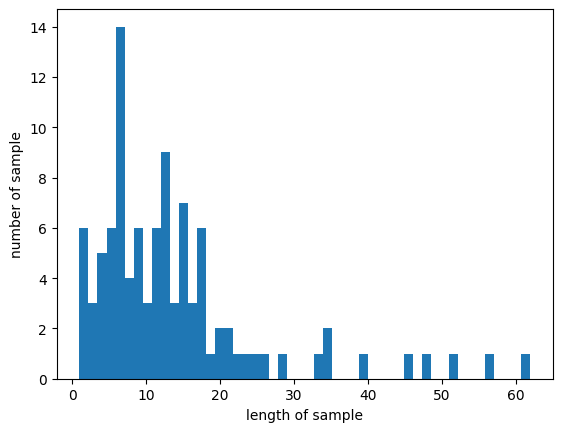

In [ ]:
max_len = max(len(l) for l in encoded)
print('리뷰의 최대 길이 : %d' % max_len)
print('리뷰의 최소 길이 : %d' % min(len(l) for l in encoded))
print('리뷰의 평균 길이 : %f' % (sum(map(len, encoded))/len(encoded)))
plt.hist([len(s) for s in encoded], bins=50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

In [ ]:
for line in encoded:
    if len(line) < max_len: # 현재 샘플이 정해준 길이보다 짧으면
        line += [word_to_index['pad']] * (max_len - len(line)) # 나머지는 전부 'pad' 토큰으로 채운다.

In [ ]:
[word_to_index['pad']]*10

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
[0]*10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
print('리뷰의 최대 길이 : %d' % max(len(l) for l in encoded))
print('리뷰의 최소 길이 : %d' % min(len(l) for l in encoded))
print('리뷰의 평균 길이 : %f' % (sum(map(len, encoded))/len(encoded)))

리뷰의 최대 길이 : 62
리뷰의 최소 길이 : 62
리뷰의 평균 길이 : 62.000000


In [ ]:
 max(len(l) for l in encoded)

62

In [ ]:
print(encoded[:3])

[[79, 27, 9, 4, 50, 42, 80, 16, 28, 29, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [188, 5, 81, 189, 190, 191, 43, 192, 113, 5, 193, 194, 24, 114, 195, 196, 13, 51, 82, 115, 30, 43, 197, 116, 117, 31, 198, 5, 199, 200, 17, 113, 7, 68, 52, 17, 44, 201, 5, 202, 4, 203, 14, 7, 83, 32, 204, 84, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [205, 118, 206, 53, 207, 31, 208, 209, 54, 10, 25, 11, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


In [ ]:
import urllib.request
import pandas as pd

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv", filename="IMDb_Reviews.csv")

('IMDb_Reviews.csv', <http.client.HTTPMessage at 0x7e558272fee0>)

In [ ]:
df = pd.read_csv('IMDb_Reviews.csv', encoding='latin1')
df.head()

,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


In [ ]:
print('전체 샘플의 개수 : {}'.format(len(df)))

전체 샘플의 개수 : 50000


In [ ]:
train_df = df[:25000]
test_df = df[25000:]

In [ ]:
train_df.to_csv("train_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

In [ ]:
train_df.to_csv("/content/drive/MyDrive/test/train_data.csv", index=False)
test_df.to_csv("/content/drive/MyDrive/test/test_data.csv", index=False)

In [ ]:
from torchtext.legacy import data # torchtext.data 임포트

# 필드 정의
TEXT = data.Field(sequential=True,
                  use_vocab=True,
                  tokenize=str.split,
                  lower=True,
                  batch_first=True,
                  fix_length=20)

LABEL = data.Field(sequential=False,
                   use_vocab=False,
                   batch_first=False,
                   is_target=True)

ModuleNotFoundError: ignored

In [ ]:
# Configuration
runtimeFlag = "cuda:0" #Run on GPU (you can't run GPTQ on cpu)
cache_dir = None # by default, don't set a cache directory. This is automatically updated if you connect Google Drive.
scaling_factor = 1.0 # allows for a max sequence length of 16384*6 = 98304! Unfortunately, requires Colab Pro and a V100 or A100 to have sufficient RAM.

In [ ]:
# Set the SYSTEM PROMPT
DEFAULT_SYSTEM_PROMPT = 'You are a helpful pair-coding assistant.'
SYSTEM_PROMPT = DEFAULT_SYSTEM_PROMPT

print(SYSTEM_PROMPT)

You are a helpful pair-coding assistant.


### Google Drive Mounting (optional)
- Allows you to download the model to Google Drive for faster startup next time.

In [ ]:
# import os
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# ## Allow the model to be saved to Google Drive for faster startup next time

# # This is the path to the Google Drive folder.
# drive_path = "/content/drive"

# # This is the path where you want to store your cache.
# cache_dir_path = os.path.join(drive_path, "My Drive/huggingface_cache")

# # Check if the Google Drive folder exists. If it does, use it as the cache_dir.
# # If not, set cache_dir to None to use the default Hugging Face cache location.
# if os.path.exists(drive_path):
#     cache_dir = cache_dir_path
#     os.makedirs(cache_dir, exist_ok=True) # Ensure the directory exists
# else:
#     cache_dir = None

# print(cache_dir)

## Install

In [ ]:
!pip install -q -U transformers peft accelerate optimum

!pip install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.6/380.6 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install -q -U pdfminer.six # could maybe add pre-built wheels to speed this up.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 47.7 MB/s eta 0:00:00


In [ ]:
# https://stackoverflow.com/questions/56081324/why-are-google-colab-shell-commands-not-working
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

### Import

In [ ]:
import transformers
import torch
import json
import os
from transformers import AutoTokenizer, TextStreamer

## Load Model
If you have connected to Google Drive, the model will load from there (unless this is your first time connecting, in which case the model will be saved to Drive).
- Takes about 2 mins first time around.
- Takes about 1 min the 2nd time onwards with Google Drive.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    # rope_scaling = {"type": "dynamic", "factor": scaling_factor}
    )
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
print(model.config.max_position_embeddings)

16384


In [ ]:
print(model.config)

LlamaConfig {
  "_name_or_path": "TheBloke/CodeLlama-13B-Instruct-GPTQ",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "auto_map": {
    "AutoConfig": "TheBloke/CodeLlama-13B-Instruct-GPTQ--configuration_llama.LlamaConfig",
    "AutoModel": "TheBloke/CodeLlama-13B-Instruct-GPTQ--modeling_llama.LlamaModel",
    "AutoModelForCausalLM": "TheBloke/CodeLlama-13B-Instruct-GPTQ--modeling_llama.LlamaForCausalLM",
    "AutoModelForSequenceClassification": "TheBloke/CodeLlama-13B-Instruct-GPTQ--modeling_llama.LlamaForSequenceClassification"
  },
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 5120,
  "initializer_range": 0.02,
  "intermediate_size": 13824,
  "max_position_embeddings": 16384,
  "model_type": "llama",
  "num_attention_heads": 40,
  "num_hidden_layers": 40,
  "num_key_value_heads": 40,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "quantization_config": {
    "batch_size": 1,
    "bits": 4,
    "block_name_to_quantize": null,
    "damp_percen

## Set up the User Interface

In [ ]:
from IPython.display import display, HTML, clear_output, Markdown
import textwrap, json
import ipywidgets as widgets
import re, time
from google.colab import files
from pdfminer.high_level import extract_text
import io

In [ ]:
B_INST, E_INST = "[INST]", "[/INST]"
B_SYS, E_SYS = "<<SYS>>\n", "\n<</SYS>>\n\n"

# max_doc_length = 50
max_context = int(model.config.max_position_embeddings*scaling_factor)
max_doc_length = int(0.75 * max_context)  # max doc length is 75% of the context length
max_doc_words = int(max_doc_length)

In [ ]:
def generate_response(dialogs, temperature=0.01, top_p=0.9, logprobs=False):
    torch.cuda.empty_cache()
    # print(json.dumps(dialogs, indent=4))
    max_prompt_len = int(0.85 * max_context)
    max_gen_len = int(0.10 * max_prompt_len)

    prompt_tokens = []
    for dialog in dialogs:
        if dialog[0]["role"] != "system":
            dialog = [
                {
                    "role": "system",
                    "content": SYSTEM_PROMPT,
                }
            ] + dialog
        dialog_tokens = [tokenizer(
            f"{B_INST} {B_SYS}{(dialog[0]['content']).strip()}{E_SYS}{(dialog[1]['content']).strip()} {E_INST}",
            # f"{B_INST} {(dialog[1]['content']).strip()} {E_INST}", # Omits the system prompt altogether
            return_tensors="pt",
            add_special_tokens=True
        ).input_ids.to(runtimeFlag)]
        for i in range(2, len(dialog), 2):
            user_tokens = tokenizer(
                f"{B_INST} {(dialog[i+1]['content']).strip()} {E_INST}",
                return_tensors="pt",
                add_special_tokens=True
            ).input_ids.to(runtimeFlag)
            assistant_w_eos = dialog[i]['content'].strip() + tokenizer.eos_token
            assistant_tokens = tokenizer(
                            assistant_w_eos,
                            return_tensors="pt",
                            add_special_tokens=False
                        ).input_ids.to(runtimeFlag)
            tokens = torch.cat([assistant_tokens, user_tokens], dim=-1)
            dialog_tokens.append(tokens)
        prompt_tokens.append(torch.cat(dialog_tokens, dim=-1))

    input_ids = prompt_tokens[0]
    if len(input_ids[0]) > max_prompt_len:
        return "\n\n **The language model's input limit has been reached. Clear the chat and start afresh!**"

    # print(tokenizer.decode(input_ids[0], skip_special_tokens=True))

    generation_output = model.generate(
        input_ids=input_ids,
        do_sample=True,
        max_new_tokens=max_gen_len,
        temperature=temperature,
        top_p=top_p,
    );

    new_tokens = generation_output[0][input_ids.shape[-1]:]
    new_assistant_response = tokenizer.decode(new_tokens, skip_special_tokens=True).strip();

    return new_assistant_response

In [ ]:
def print_wrapped(text):
    # Regular expression pattern to detect code blocks
    code_pattern = r'```(.+?)```'
    matches = list(re.finditer(code_pattern, text, re.DOTALL))

    if not matches:
        # If there are no code blocks, display the entire text as Markdown
        display(Markdown(text))
        return

    start = 0
    for match in matches:
        # Display the text before the code block as Markdown
        before_code = text[start:match.start()].strip()
        if before_code:
            display(Markdown(before_code))

        # Display the code block
        code = match.group(0).strip()  # Extract code block
        display(Markdown(code))  # Display code block

        start = match.end()

    # Display the text after the last code block as Markdown
    after_code = text[start:].strip()  # Text after the last code block
    if after_code:
        display(Markdown(after_code))

dialog_history = [{"role": "system", "content": SYSTEM_PROMPT}]

button = widgets.Button(description="Send")
upload_button = widgets.Button(description="Upload .txt or .pdf")
text = widgets.Textarea(layout=widgets.Layout(width='800px'))

output_log = widgets.Output()

def on_button_clicked(b):
    user_input = text.value
    dialog_history.append({"role": "user", "content": user_input})

    text.value = ''

    # Change button description and color, and disable it
    button.description = 'Processing...'
    button.style.button_color = '#ff6e00'  # Use hex color codes for better color choices
    button.disabled = True  # Disable the button when processing

    with output_log:
        clear_output()
        for message in dialog_history:
            print_wrapped(f'**{message["role"].capitalize()}**: {message["content"]}\n')

    assistant_response = generate_response([dialog_history]);

    # Re-enable the button, reset description and color after processing
    button.description = 'Send'
    button.style.button_color = 'lightgray'
    button.disabled = False

    dialog_history.append({"role": "assistant", "content": assistant_response})

    with output_log:
        clear_output()
        for message in dialog_history:
            print_wrapped(f'**{message["role"].capitalize()}**: {message["content"]}\n')

button.on_click(on_button_clicked)

# Create an output widget for alerts
alert_out = widgets.Output()

clear_button = widgets.Button(description="Clear Chat")
text = widgets.Textarea(layout=widgets.Layout(width='800px'))

def on_clear_button_clicked(b):
    # Clear the dialog history
    dialog_history.clear()
    # Add back the initial system prompt
    dialog_history.append({"role": "system", "content": SYSTEM_PROMPT})
    # Clear the output log
    with output_log:
        clear_output()

clear_button.on_click(on_clear_button_clicked)

In [ ]:
from IPython.display import display, HTML
from ipywidgets import HBox, VBox

# Create the title with HTML
title = f"<h1 style='color: #ff6e00;'>Colab Code Llama 🦙</h1> <p>(Max context of: {max_context}. Uploaded files will be shortened to {max_doc_words} tokens)</p>"

# Assuming that output_log, alert_out, and text are other widgets or display elements...
first_row = HBox([button, clear_button])  # Arrange these buttons horizontally

# Arrange the two rows of buttons and other display elements vertically
layout = VBox([output_log, alert_out, text, first_row])

# Chat with Colab Code Llama

In [ ]:
display(HTML(title))  # Use HTML function to display the title
display(layout)

In [ ]:
def remove_spaces_and_punctuation2(input_string):
    output_string = ""
    for char in input_string:
        if char.isalnum():
            output_string += char
    return output_string

print(remove_spaces_and_punctuation2("Hello, World! 123"))

HelloWorld123


In [ ]:
def remove_spaces_and_punctuation(input_string):
    # Create an empty list to store the alphanumeric characters
    alphanumeric_chars = []

    # Iterate over each character in the input string
    for char in input_string:
        # Check if the character is a letter or a digit
        if ('A' <= char <= 'Z') or ('a' <= char <= 'z') or ('0' <= char <= '9'):
            # If it is, add it to the list of alphanumeric characters
            alphanumeric_chars.append(char)

    # Convert the list of alphanumeric characters back into a string
    modified_string = ''.join(alphanumeric_chars)

    return modified_string

# Test the function with an example string
print(remove_spaces_and_punctuation("Hello, World! 123"))

HelloWorld123


In [ ]:
def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, int(n ** 0.5) + 1):
        if n % i == 0:
            return False
    return True

def sum_of_primes(start, end):
    prime_sum = 0
    for i in range(start, end + 1):
        if is_prime(i) and  "7" not in str(i):
            prime_sum += i
    return prime_sum

print(sum_of_primes(1000000, 2000000))

45772097654


In [ ]:
def is_prime(n):
    if n <= 1:
        return False
    if n <= 3:
        return True
    if n % 2 == 0 or n % 3 == 0:
        return False
    i = 5
    while i * i <= n:
        if n % i == 0 or n % (i + 2) == 0:
            return False
        i +=6
    return True

def no_seven(n):
    return '7' not in str(n)

sum_primes = sum(i for i in range(10**6, (2*10**6)+1) if is_prime(i) and no_seven(i))
print(sum_primes)

45772097654
